# Predict tags on StackOverflow with linear models

In this notebook we will try to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task we will use multilabel classification approach.

### Data

The following cell will download all data required for this assignment into the folder `week1/data`.

In [1]:
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

File 'data\\train.tsv' successfully downloaded
File 'data\\validation.tsv' successfully downloaded
File 'data\\test.tsv' successfully downloaded
File 'data\\text_prepare_tests.tsv' successfully downloaded


### Text preprocessing

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\M.Baichere\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In this task you will deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). The *test* set is provided for Coursera's grading and doesn't contain answers. Upload the corpora using *pandas* and look at the data:

In [5]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [6]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [7]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [8]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


As you can see, *title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

In [9]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. 

**Text Preparation** 

In [10]:
import re

In [41]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE,' ',text)
    text = re.sub(BAD_SYMBOLS_RE,'',text)
    text = text.split(' ')
    text = list(filter(None, text))
    text = [word for word in text if word not in STOPWORDS]
    text = ' '.join(text)
    return text

In [42]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [43]:
print(test_text_prepare())

Basic tests are passed.


In [46]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [50]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [51]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

For each tag and for each word calculate how many times do they occur in the train corpus? 

**Word Tags Count** 

In [54]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

for i,e in enumerate(y_train):
    for element in y_train[i]:
        try:
            tags_counts[element] += 1
        except:
            tags_counts[element] = 1
    text = X_train[i].split(" ")
    for element in text:
        try:
            words_counts[element] += 1
        except:
            words_counts[element] = 1

In [52]:
y_train[:3]

array([list(['r']), list(['php', 'mysql']), list(['c#'])], dtype=object)

In [53]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

We are assuming that *tags_counts* and *words_counts* are dictionaries like `{'some_word_or_tag': frequency}`. After applying the sorting procedure, results will be look like this: `[('most_popular_word_or_tag', frequency), ('less_popular_word_or_tag', frequency), ...]`. 

    tag1,tag2,tag3
    word1,word2,word3

In [55]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this notebook we will try to use two of them.

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   

In [59]:
import operator

In [61]:
DICT_SIZE = 5000
sorted_by_value = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]

WORDS_TO_INDEX = dict(zip(words_counts.keys(), range(DICT_SIZE)))
INDEX_TO_WORDS = {v: k for k, v in WORDS_TO_INDEX.items()}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    text = text.split(" ")
    for word in text:
        try:
            result_vector[words_to_index[word]] += 1
        except: pass
    return result_vector

In [62]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [63]:
print(test_my_bag_of_words())

Basic tests are passed.


Now we apply the implemented function to all samples:

In [64]:
from scipy import sparse as sp_sparse

In [65]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [69]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """ 
    tfidf_vectorizer = TfidfVectorizer(max_df = 0.9,min_df =5,ngram_range =(1,2))
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once you have done text preprocessing, always have a look at the results. Be very careful at this step, because the performance of future models will drastically depend on it. 

In [70]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [71]:
tfidf_reversed_vocab

{4486: 'draw',
 14488: 'stacked',
 10007: 'mysql',
 13575: 'select',
 12574: 'records',
 3785: 'datetime',
 5497: 'field',
 8711: 'less',
 14351: 'specified',
 16640: 'value',
 10037: 'mysql select',
 13610: 'select records',
 3788: 'datetime field',
 15234: 'terminate',
 17343: 'windows',
 11310: 'phone',
 162: '81',
 807: 'app',
 17364: 'windows phone',
 11311: 'phone 81',
 163: '81 app',
 6331: 'get',
 3426: 'current',
 15411: 'time',
 14306: 'specific',
 3231: 'country',
 16918: 'via',
 8291: 'jquery',
 6361: 'get current',
 3443: 'current time',
 15438: 'time specific',
 16931: 'via jquery',
 2844: 'configuring',
 15501: 'tomcat',
 16181: 'use',
 14474: 'ssl',
 1291: 'awesome',
 10163: 'nested',
 13877: 'set',
 11586: 'plugin',
 331: 'add',
 10227: 'new',
 2301: 'children',
 15576: 'tree',
 16872: 'various',
 8725: 'levels',
 378: 'add new',
 3254: 'create',
 9301: 'map',
 8411: 'json',
 12962: 'response',
 13252: 'ruby',
 12331: 'rails',
 8438: 'json response',
 13267: 'ruby rail

Now, we use this transormation for the data and check again.

In [77]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """   
    tfidf_vectorizer = TfidfVectorizer(token_pattern = '(\S+)', max_df = 0.9,min_df =5,ngram_range =(1,2))
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [78]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [79]:
tfidf_reversed_vocab

{4792: 'draw',
 14941: 'stacked',
 12748: 'r',
 10394: 'mysql',
 14019: 'select',
 13008: 'records',
 4089: 'datetime',
 5815: 'field',
 9077: 'less',
 14801: 'specified',
 17129: 'value',
 10426: 'mysql select',
 14054: 'select records',
 4093: 'datetime field',
 15706: 'terminate',
 17849: 'windows',
 11715: 'phone',
 243: '81',
 887: 'app',
 17871: 'windows phone',
 11718: 'phone 81',
 244: '81 app',
 6669: 'get',
 3725: 'current',
 15887: 'time',
 14756: 'specific',
 3531: 'country',
 17419: 'via',
 8651: 'jquery',
 6700: 'get current',
 3742: 'current time',
 15916: 'time specific',
 17433: 'via jquery',
 3142: 'configuring',
 15979: 'tomcat',
 16672: 'use',
 14927: 'ssl',
 1378: 'awesome',
 10551: 'nested',
 14326: 'set',
 11993: 'plugin',
 415: 'add',
 10616: 'new',
 2590: 'children',
 16059: 'tree',
 17370: 'various',
 9091: 'levels',
 461: 'add new',
 3554: 'create',
 9682: 'map',
 8773: 'json',
 13398: 'response',
 13692: 'ruby',
 12777: 'rails',
 146: '3',
 8801: 'json respo

### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s.

In [80]:
from sklearn.preprocessing import MultiLabelBinarizer

In [81]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [82]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [87]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    ovr = OneVsRestClassifier(LogisticRegression())
    return ovr.fit(X_train, y_train)

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [88]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [89]:
classifier_mybag

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [90]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [91]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 

In [92]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [97]:
def print_evaluation_scores(y_val, predicted):
    print("accuracy : " + str(accuracy_score(y_val,predicted)))
    print("f1_score : " + str(f1_score(y_val,predicted,average = 'weighted')))
    print("precision : " + str(average_precision_score(y_val,predicted)))

In [98]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
accuracy : 0.34863333333333335
f1_score : 0.6399730933373576
precision : 0.3410795927412601
Tfidf
accuracy : 0.33393333333333336
f1_score : 0.614350867051105
precision : 0.30203064788106676


We will also plot some generalization of the [ROC curve]
 - true labels
 - decision functions scores
 - number of classes

In [99]:
from metrics import roc_auc
%matplotlib inline

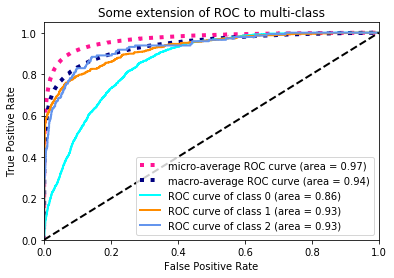

In [100]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

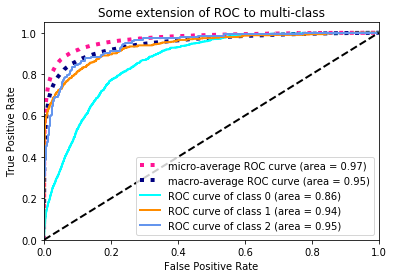

In [101]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

Once we have the evaluation set up, we will train our classifiers. We will use *F1-score weighted* as an evaluation metric:

In [122]:
def train_classifier(X_train, y_train,c):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    ovr = OneVsRestClassifier(LogisticRegression(penalty ='l1',C = c))
    return ovr.fit(X_train, y_train)

list_values = [0.1,1,10]
for c in list_values:
    classifier = train_classifier(X_train_tfidf, y_train, c)
    y_val_predicted_labels = classifier.predict(X_val_tfidf)
    print("f1_score : " + str(f1_score(y_val,y_val_predicted_labels,average = 'weighted')) + " , C : " + str(c))

C:\Users\M.Baichere\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score : 0.5664298127743825 , C : 0.1
f1_score : 0.6524311839672936 , C : 1
f1_score : 0.6481068007504692 , C : 10


In [124]:
ovr = OneVsRestClassifier(LogisticRegression(penalty ='l1',C = 3))
clf = ovr.fit(X_train_tfidf,y_train)

test_predictions = clf.predict(X_test_tfidf)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))

Current answer for task MultilabelClassification is:
 0	mysql,php
1	html,javascript,jquery
2	
3	javascript,jquery
4	android,java
5	parsing,php,xml
6	json,...
